In [ ]:
using RxInfer
using TOML
using VBMC
using Distributions
using Random
using StatsBase
using LogarithmicNumbers
using CSV
using DataFrames

Random.seed!(1234)
if "test" in readdir()
    cd("test")
end

struct MetaTransition
    mat :: Matrix{Float64}
    t :: Int
end

struct TmmEnd
    wt :: AbstractArray{T}
end

struct TmmTransition{T <: Real} <: DiscreteMultivariateDistribution
    wpast :: AbstractArray{T}
    wt :: AbstractArray{T}
end

vars = TOML.parsefile("Constants.toml")
T, U, X, Y = 3, 2, 2, 2

P1 = begin
    ones(U*X*Y) |>
    Dirichlet |>
    rand |>
    (x -> Categorical(x)) |>
    (d -> ReshapedCategorical(d, U, X, Y))
end

 Pt = begin
    rand(Dirichlet(ones(U*X*Y)), U * X * Y) |>
    W -> reshape(W, (U, X, Y, U, X, Y)) |> TransitionDistribution
end

TransitionDistribution([0.042948586875540117 0.35681049836519085; 0.06369004888813805 0.23236967238475587;;; 0.001243877995951349 0.14544653318674342; 0.013167064266389963 0.14432371803729022;;;; 0.13239152639780546 0.035934317842011974; 0.0851597853717087 0.05901636614540095;;; 0.22239411855655505 0.33816939673228597; 0.0518954578708727 0.07503903108335924;;;;; 0.038269445730694705 0.11819691313524285; 0.29679398769308 0.16169201672660707;;; 0.19860267869588516 0.006030155519634674; 0.04902889662367154 0.1313859058751839;;;; 0.15473601872420537 0.15739701600307732; 0.04468651051340867 0.015423061020201384;;; 0.2823125528601406 0.1523004869034251; 0.005919623285885637 0.18722473068965595;;;;;; 0.13866011146645835 0.17883469897909926; 0.04226881282646806 0.05075595507787147;;; 0.11905192531972249 0.21399818445306787; 0.07934490876897328 0.177085403108339;;;; 0.023295741273374276 0.06206548428641996; 0.21332506358219003 0.11142051724489566;;; 0.025843955835009445 0.38627691019589505; 0.0

In [14]:
tmm_gen = TmmDistribution(P1, Pt)
tmm = rand(tmm_gen, T)

TMM([1, 2, 1], [2, 1, 2], [2, 2, 2])

In [ ]:
function get_x(w)
    VBMC.reshapeindex(w, U, X)[2]
end
function get_u(w)
    VBMC.reshapeindex(w, U, X)[1]
end

@node TmmTransition Stochastic [wt, wp]
@rule TmmTransition(:wp, Marginalisation) (q_wt :: Categorical, meta::MetaTransition) = begin
    println("^Tere")
    println(meta.t, " .")
    G = q_wt.p
    A = meta.mat
    ηs = exp.(log.(A)' * G)
    νs = ηs ./ sum(ηs)
    return Categorical(νs...)
end
@rule TmmTransition(:wt, Marginalisation) (q_wp :: Categorical, meta::MetaTransition) = begin
    println("Tere2")
    println(meta.t, " .")
    F = q_wp.p
    A = meta.mat
    ηs = exp.(log.(A) * F) # .* B # | clamp(⋅,tiny,one) | exp maybe or smth?
    νs = ηs ./ sum(ηs)
    return Categorical(νs...)
end
@marginalrule TmmTransition(:wt_wp) (q_wt::Categorical, q_wp::Categorical, meta::MetaTransition) = begin
    println("Tere3")
    println(meta.t, " .")
    F, G = q_wp.p, q_wt.p
    A = meta.mat
    ηs = exp.(log.(A) * F) # .* B
    ps = ηs .* G
    ps = ps ./ sum(ps)
    return (wt = Categorical(ps...), wp = q_wp)
end
@average_energy TmmTransition (q_wt::Categorical, q_wp::Categorical, meta::MetaTransition) = begin
    println("Ter4")
    println(meta.t, " .")
    A = meta.mat
    G, F = q_wp.p, q_wt.p
    F' * log.(A) * G
end

@node TmmEnd Stochastic [w]
@rule TmmEnd(:w, Marginalisation) (,) = begin
    return Categorical(U*X)
end
@rule Identity3(:y, Marginalisation) (q_w :: Categorical,) = begin
    return PointMass(1.)
end
@marginalrule Identity3(:w_y) (q_w::Categorical, q_y::PointMass) = begin
    return (wt = Categorical(q_w), y = q_y)
end
@average_energy Identity3 (q_w::Categorical, q_y::PointMass) = begin
    mean(q_w)
end

constraints = @constraints begin
    # q(w) = q(w[begin])..q(w[end])
    q(a, b, c) = q(a)q(b)q(c)
end

init = @initialization begin
    # for t in 2:T-1
    #     q(w[t]) = vague(Categorical, U*X)
    # end
    q(a) = vague(Categorical, U*X)
    q(b) = vague(Categorical, U*X)
    q(c) = vague(Categorical, U*X)
end;

In [48]:
p1s = reshape(P1.d.p, (U,X,Y))[:,:,tmm.Y[1]] |> Iterators.flatten |> collect
p1s = p1s ./ sum(p1s)
@eval @model function hidden_markov_model(y)
    a ~ Categorical(p1s)
    b ~ TmmTransition(a) where { meta = MetaTransition(reshape(Pt.mat[:,:,y[2],:,:,y[2-1]], U*X, U*X), 2) }
    c ~ TmmTransition(b) where { meta = MetaTransition(reshape(Pt.mat[:,:,y[3],:,:,y[3-1]], U*X, U*X), 3) }
    # c ~ PointMass(c)
end

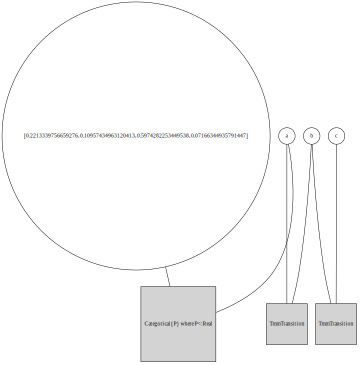

In [49]:
using GraphViz
model_generator = hidden_markov_model() | (y = tmm.Y,)
model_to_plot = RxInfer.getmodel(RxInfer.create_model(model_generator))
GraphViz.load(model_to_plot, strategy = :simple, layout="dot", width=5.,height=10.)

In [41]:
infer(
    model = hidden_markov_model(),
    constraints = constraints,
    initialization = init,
    data = (y = tmm.Y,),
    options = (limit_stack_depth = 500,),
    free_energy = true,
    showprogress=true,
    iterations = 1,
    warn = false
)
function find_viterbi(posteriors_w)
    posteriors_w .|> dist -> (sum(reshape(dist.p, U, X), dims=1) |> Iterators.flatten |> collect |> argmax)
end

LoadError: UndefRefError: access to undefined reference